In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

2024-05-04 17:07:44.041529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/SAGOR/Unknown/AI_Works/Lip_Reading_code/lip_venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

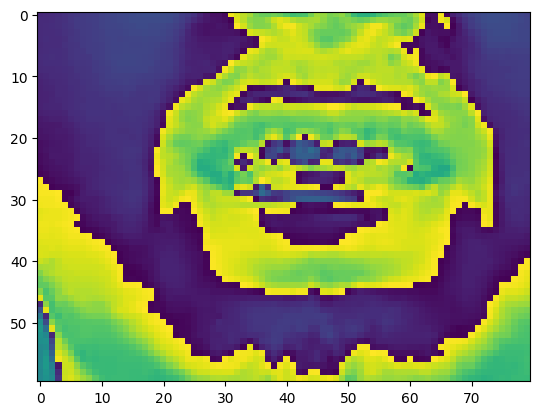

In [4]:
# https://github.com/skaws2003/Dlib-lip-detection/tree/master

import dlib

def load_video(path:str) -> List[float]: 
    hog_face_detector = dlib.get_frontal_face_detector()
    dlib_facelandmark = dlib.shape_predictor("./detector/shape_predictor_68_face_landmarks.dat")

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = hog_face_detector(frame)

        x67, y67 = 100, 100
        horizontal_padding, vertical_padding = 40, 30
        for face in faces:
            face_landmarks = dlib_facelandmark(frame, face)
            # for n in range(0, 68):
            #     x = face_landmarks.part(n).x
            #     y = face_landmarks.part(n).y
            #     cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
            x67 = face_landmarks.part(67).x
            y67 = face_landmarks.part(67).y
        lip_window = frame[y67-vertical_padding:y67+vertical_padding, x67-horizontal_padding:x67+horizontal_padding]
        lip_window = tf.expand_dims(lip_window, axis=-1)
            
        frames.append(lip_window)
    cap.release()
    # return frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


test_path = './data/person0/clips/clip0.mp4'
frm = load_video(test_path)

plt.imshow(frm[20])

In [ ]:
vocab = [x for x in " অআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহড়ঢ়য়ৎংঃঁািীুূেৈোৌৃ"]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} \n"
    f"(size ={char_to_num.vocabulary_size()})"
)

In [ ]:
char_to_num([' ','অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ'])

In [ ]:
print([bytes.decode(x) for x in num_to_char([14,  9,  3, 11, 13]).numpy()])

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        for word in line:
            for char in word:
                tokens.extend(char)
            tokens.extend(' ')
    # print(tokens)
    return char_to_num(tokens)[:-1]

test_path = './data/person0/texts/clip1.txt'
tokens = load_alignments(test_path)
print(tokens)
print([bytes.decode(x) for x in num_to_char(tokens).numpy()])

In [ ]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # # File name splitting for windows
    # # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','person0','clips', f'{file_name}.mp4')
    alignment_path = os.path.join('data','person0','texts',f'{file_name}.txt')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
# for windows
# test_path = '.\\data\\person0\\clips\\clip0.mp4'
test_path = './data/person0/clips/clip0.mp4'

In [ ]:
# for windows
# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
# load_data(tf.convert_to_tensor(test_path))

In [ ]:
plt.imshow(frames[15])
# frames[23]

In [ ]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline

In [ ]:
import random
from glob import glob

# files = glob('./data/person0/clips/*.mp4')
# print(f'Total files: {len(files)}')


base_directory = './data/'
videos_directory = os.path.join(base_directory, 'person0', 'clips')
pattern = os.path.join(videos_directory, '**', '*.mp4')
files = glob(pattern, recursive=True)
random.shuffle(files)

print(f'Total files: {len(files)}')

# Split the data into train, validation, and test sets
train_size = int(0.86 * len(files))
val_size = int(0.07 * len(files))
test_size = len(files) - train_size - val_size

# Split the files list into train, validation, and test sets
train_files = files[:train_size]
val_files = files[train_size:train_size + val_size]
test_files = files[train_size + val_size:]

train_size = len(train_files)
val_size = len(val_files)
test_size = len(test_files)
print(f'Train size: {train_size}\nValidation size: {val_size}\nTest size: {test_size}')
print(train_files[0])
print(val_files[0])
print(test_files[0])

# Load datasets from file paths
train_data = tf.data.Dataset.from_tensor_slices(train_files)
val_data = tf.data.Dataset.from_tensor_slices(val_files)
test_data = tf.data.Dataset.from_tensor_slices(test_files)

# Shuffle the datasets
train_data = train_data.shuffle(train_size, reshuffle_each_iteration=False)
val_data = val_data.shuffle(val_size, reshuffle_each_iteration=False)
test_data = test_data.shuffle(test_size, reshuffle_each_iteration=False)

# Map preprocessing function and batch the datasets
train_data = train_data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the datasets
batch_size = 2
tot_frames = 95
tot_chars = 40
train_data = train_data.padded_batch(batch_size, padded_shapes=([tot_frames, None, None, None], [tot_chars]))
val_data = val_data.padded_batch(batch_size, padded_shapes=([tot_frames, None, None, None], [tot_chars]))
test_data = test_data.padded_batch(batch_size, padded_shapes=([tot_frames, None, None, None], [tot_chars]))

# Prefetch the datasets
train_data = train_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
sample = train_data.as_numpy_iterator()
val = sample.next()
# print(val[1])

In [ ]:
sample1 = val_data.as_numpy_iterator()
val1 = sample.next()
# print(val[1])

In [ ]:
sample2 = test_data.as_numpy_iterator()
val2 = sample.next()
# print(val[1])

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][20])

In [ ]:
# tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

words = [num_to_char(word) for word in val[1][0]]
joined_words = tf.strings.reduce_join(words).numpy().decode('utf-8')
print(joined_words)

# Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
train_data.as_numpy_iterator().next()[0][0].shape

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(tot_frames,60,80,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(tot_frames, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(256, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(256, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

In [ ]:
print(f'input shape: {model.input_shape}')
print(f'output shape: {model.output_shape}')

# Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        
        decoded = tf.keras.backend.ctc_decode(yhat, [tot_frames, tot_frames], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
class AccuracyExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        self.total_chars = 0
        self.correct_chars = 0
        self.total_words = 0
        self.correct_words = 0

    def on_epoch_begin(self, epoch, logs=None) -> None:
        self.dataset_iterator = self.dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, logs=None) -> None:
        self.total_chars = 0
        self.correct_chars = 0
        self.total_words = 0
        self.correct_words = 0
        
        for data in self.dataset_iterator:
            y_true = data[1]
            y_pred = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(y_pred, [tot_frames, tot_frames], greedy=False)[0][0].numpy()

            for x in range(len(y_pred)):
                true_str = tf.strings.reduce_join(num_to_char(y_true[x])).numpy().decode('utf-8')
                decoded_str = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
                self.total_chars += len(true_str)
                self.correct_chars += sum(1 for true_char, pred_char in zip(true_str, decoded_str) if true_char == pred_char)
                self.total_words += len(true_str.split())
                self.correct_words += sum(1 for true_word, pred_word in zip(true_str.split(), decoded_str.split()) if true_word == pred_word)

        char_accuracy = self.correct_chars / self.total_chars if self.total_chars > 0 else 0
        word_accuracy = self.correct_words / self.total_words if self.total_words > 0 else 0
        print(f"Epoch: {epoch + 1} - char_accuracy: {char_accuracy*100:.4f}% - word_accuracy: {word_accuracy*100:.4f}%")


In [ ]:

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join('bangla_model','checkpoint'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
    ) 

schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

example_callback = ProduceExample(val_data)
accuracy_callback = AccuracyExample(val_data)

backup_callback = tf.keras.callbacks.BackupAndRestore(
    os.path.join('bangla_training_backup'),
    save_freq='epoch',
    delete_checkpoint=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=[
                    backup_callback, checkpoint_callback, schedule_callback, early_stopping, example_callback, accuracy_callback,])

# Make Predictions

In [ ]:
# for windows
# model.load_weights('.\\models\\checkpoint')
model.load_weights('./bangla_model/checkpoint')

In [ ]:
val_single = val_data.as_numpy_iterator()

for _ in range(20):
    data = val_single.next()
    yhat = model.predict(data[0])
    
    decoded = tf.keras.backend.ctc_decode(yhat, [tot_frames, tot_frames], greedy=False)[0][0].numpy()
    for x in range(len(yhat)):           
        print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
        print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
        print('~'*100)

In [ ]:
test_single = test_data.as_numpy_iterator()

for _ in range(20):
    data = test_single.next()
    yhat = model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yhat, [tot_frames, tot_frames], greedy=False)[0][0].numpy()
    for x in range(len(yhat)):
        print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
        print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
        print('~'*100)